## Welch spectrogram hyperparameter tuning

In [1]:
import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
import tensorflow_probability as tfp
from tensorflow.keras import backend as K

## import functions
import sys
sys.path.append("..")
from src import GetParquet
from src import Train_test_sets_maker
from src import MinMaxNormalisation
from src import CoxboxTransform
from src import Visualize
from src import MIMII_AE
from src import AE_variant1

In [10]:
def GetNormalizeData(method,ID): 
       # import data
    df_normal, df_abnormal = GetParquet.fun(1,ID,method)
    # create datasets
    train_set, test_set, test_labels = Train_test_sets_maker.fun(df_normal,df_abnormal)
    # normalize [0,1]
    MIN,MAX = MinMaxNormalisation.getMinMax(train_set)
    
    train_set = MinMaxNormalisation.fun(train_set,MIN,MAX)
    test_set = MinMaxNormalisation.fun(test_set,MIN,MAX)
    
    return train_set,test_set,test_labels

In [37]:
train_set,test_set,test_labels = GetNormalizeData(method = 0,ID = 2)
#train_set = CoxboxTransform.fun(train_set+1)
#test_set = CoxboxTransform.fun(test_set+1)

Data acquired !
Train & test sets created !


- reconstruct the 319 vectors of dimensions (1x320)
- train the algorithm to reconstruct this specific kinf of vector
- assess the performance for the testset

[Text(0.5, 1.0, 'Mel-freq spectro : reconstructed data')]

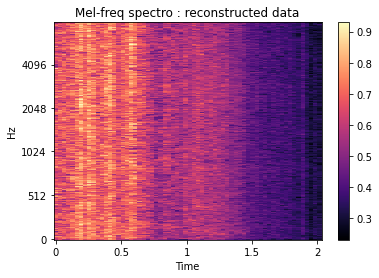

In [47]:
# Reconstructed data
import numpy as np
spectrogram_flat = np.array(test_set.iloc[260,:])
spectrogram = spectrogram_flat.reshape(313,64)

import librosa
import matplotlib.pyplot as plt
import librosa.display
fig, ax = plt.subplots()
img = librosa.display.specshow(spectrogram, x_axis='time',y_axis='mel', sr=16000, ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title='Mel-freq spectro : reconstructed data')

In [48]:
import pandas as pd
def reshape_Spec(tf_set):
    
    """ Takes the (1,20032) input vectors and reshape them to become (1,64) """
    df = None
    for raw in range(tf_set.shape[0]):
    # parcour les 313 vecteurs
        spectrogram_flat = np.array(tf_set.iloc[raw])
        spectrogram = spectrogram_flat.reshape(313,64)
        spec_df = pd.DataFrame(spectrogram)

        if df is None:
            df = spec_df        
        else:
            df = pd.concat([df,spec_df],ignore_index = True)

    return df

In [49]:
df_train = reshape_Spec(train_set)
df_test = reshape_Spec(test_set)

In [50]:
autoencoder = MIMII_AE.fun(df_train.shape[1])
# Train algorithm
history = autoencoder.fit(df_train, df_train, 
                          epochs=50, 
                          batch_size=512,
                          validation_data=(df_test,df_test),
                          validation_split = 0.1,
                          verbose = 1,
                          shuffle=True
                         )

Epoch 1/50
402/402 [==============================] - 3s 6ms/step - loss: 0.0157 - val_loss: 0.0038
Epoch 2/50
402/402 [==============================] - 1s 3ms/step - loss: 0.0024 - val_loss: 0.0030
Epoch 3/50
402/402 [==============================] - 1s 3ms/step - loss: 0.0023 - val_loss: 0.0030
Epoch 4/50
402/402 [==============================] - 1s 3ms/step - loss: 0.0022 - val_loss: 0.0030
Epoch 5/50
402/402 [==============================] - 1s 3ms/step - loss: 0.0022 - val_loss: 0.0030
Epoch 6/50
402/402 [==============================] - 1s 3ms/step - loss: 0.0022 - val_loss: 0.0030
Epoch 7/50
402/402 [==============================] - 1s 3ms/step - loss: 0.0022 - val_loss: 0.0030
Epoch 8/50
402/402 [==============================] - 1s 3ms/step - loss: 0.0022 - val_loss: 0.0030
Epoch 9/50
402/402 [==============================] - 1s 3ms/step - loss: 0.0022 - val_loss: 0.0030
Epoch 10/50
402/402 [==============================] - 1s 3ms/step - loss: 0.0022 - val_loss: 0.0030

In [51]:
test_set_shape = test_set.shape[0]

import tensorflow as tf
from tensorflow import losses

def lossCalcMSE(model,data):
    reconstructions = model(data)
    return tf.keras.losses.mse(reconstructions,data)
lossValues = []
for raw_index in range(test_set.shape[0]):
        # parcour les 313 vecteurs
        spectrogram_flat = np.array(test_set.iloc[raw_index])
        spectrogram = spectrogram_flat.reshape(313,64)
        spec_df = pd.DataFrame(spectrogram)
        spec_tf = tf.cast(spec_df, tf.float32)
        ### Function used for AUC computation :
        lossValues.append(np.mean(lossCalcMSE(autoencoder, spec_tf)))  

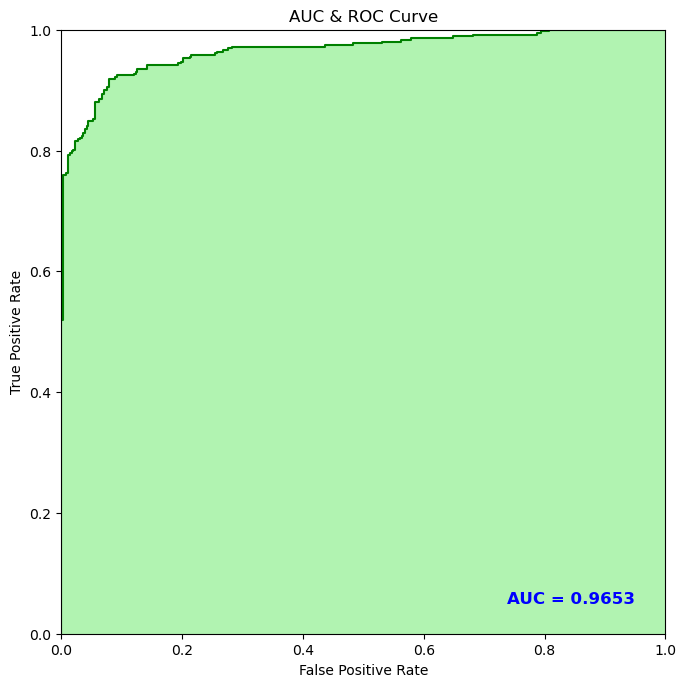

In [55]:
import sklearn
from sklearn import metrics
AUC =  metrics.roc_auc_score(~test_labels, lossValues)
false_positive_rate, true_positive_rate, thresolds = metrics.roc_curve(~test_labels, lossValues)
    
plt.figure(figsize=(10, 8), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve")
plt.plot(false_positive_rate, true_positive_rate, 'g')
plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
plt.text(0.95, 0.05, 'AUC = %0.4f' % AUC, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()